# Building Generative Models for Discrete Data via Discrete Interpolants

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import moco

import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
from tqdm import tqdm

## Tutorial

This notebook walks through how to use 3 discrete data interpolants: (1) Discrete Flow Matching (2) Discrete Denoising Diffusion Probabilistic Models, and (3) Masked Diffusion Language Modeling

## Task

here our object contains 10 binary elements with the goal distribution being a uniform distribution over the 10 elements.

We initalize our interpolants with a binary uniform prior so on average each sample with have a value of 5 out of 10

# Define the Model Architecture

In [2]:
# training
B = 32 # batch size
D = 10 # dimension
S = 2 # state space

class Model(nn.Module):
    def __init__(self, D, S):
        super().__init__()
        self.embedding = nn.Embedding(S+1, 16)
        self.net = nn.Sequential(
            nn.Linear(17 * D, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, S*D),
        )

    def forward(self, x, t):
        B, D = x.shape
        x_emb = self.embedding(x) # (B, D, 16)
        net_input = torch.cat([x_emb, t[:, None, None].repeat(1, D, 1)], dim=-1).reshape(B, -1) # (B, D * 17)
        return self.net(net_input).reshape(B, D, S) # (B, D, S)

model = Model(D, S)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Define the Discret Flow Matching Interpolant

In [3]:
from bionemo.moco.distributions.prior import DiscreteUniformPrior
from bionemo.moco.interpolants import DiscreteFlowMatcher
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule


DEVICE = "cuda:0"
prior = DiscreteUniformPrior(num_classes=S)
time_distribution = UniformTimeDistribution()
dfm = DiscreteFlowMatcher(time_distribution=time_distribution,
                          prior_distribution=prior,
                          device=DEVICE)
schedule = LinearInferenceSchedule(nsteps = 1000)

## Train DFM

In [4]:
model = model.to(DEVICE)
losses = []
for _ in tqdm(range(50000)):
    num_ones = torch.randint(0, D+1, (B,))
    x1 = (torch.arange(D)[None, :] < num_ones[:, None]).long().to(DEVICE)
    # x1 e.g. [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] or [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
    optimizer.zero_grad()
    x0 = dfm.sample_prior(x1.shape) # B x D
    t = dfm.sample_time(B)
    xt = dfm.interpolate(x1, t, x0)
    logits = model(xt, t) # (B, D, S)
    loss = dfm.loss(logits, x1, t).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:59<00:00, 845.07it/s]


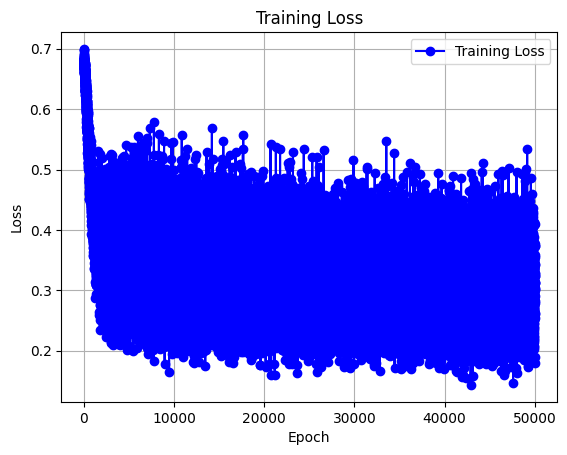

In [5]:
plt.plot(losses, label='Training Loss', linestyle='-', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.show()

## Sample from DFM

In [7]:
num_samples = 1000
xt = dfm.sample_prior((num_samples, D))
print(xt.shape)
ts = schedule.generate_schedule(device=DEVICE)
dts = schedule.discretize(device=DEVICE)

torch.Size([1000, 10])


In [8]:
for dt, t in zip(dts, ts):
    t = torch.full((xt.shape[0],), t).to(DEVICE)
    logits = model(xt, t)
    xt = dfm.step(logits, t, xt, dt)

## Generated DFM Samples

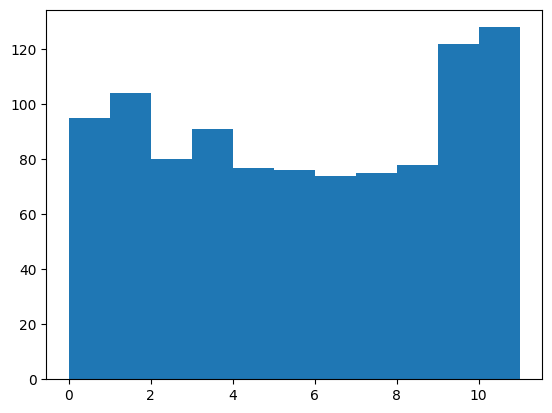

In [9]:
counts = xt.cpu().sum(dim=1).float()
plt.hist(counts.numpy(), bins=range(D+2))
plt.show()

## Ground Truth Distribution

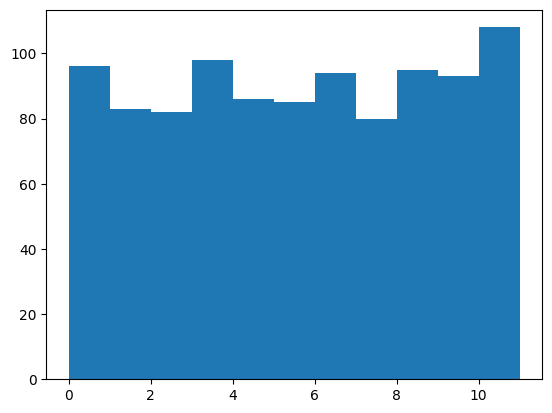

In [10]:
num_ones = torch.randint(0, D+1, (1000,))
x1 = (torch.arange(D)[None, :] < num_ones[:, None]).long()
counts = x1.cpu().sum(dim=1).float()
plt.hist(counts.numpy(), bins=range(D+2))
plt.show()

## Discrete Uniform Prior Distribution

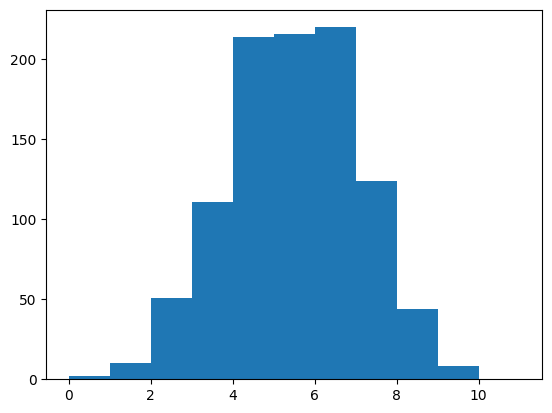

In [11]:
x0 = dfm.sample_prior((1000, D))
counts = x0.cpu().sum(dim=1).float()
plt.hist(counts.numpy(), bins=range(D+2))
plt.show()

## We see that with DFM we are able to approximate the ground truth distribution.Now let's try a different interpolant

# D3PM Interpolant

In [3]:
from bionemo.moco.distributions.prior import DiscreteUniformPrior
from bionemo.moco.interpolants import D3PM
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.schedules.noise.discrete_noise_schedules import DiscreteCosineNoiseSchedule
from bionemo.moco.schedules.inference_time_schedules import DiscreteLinearInferenceSchedule

DEVICE = "cuda:0"
prior = DiscreteUniformPrior(num_classes=S)
time_distribution = UniformTimeDistribution(discrete_time = True, nsteps = 1000)
noise_schedule = DiscreteCosineNoiseSchedule(nsteps = 1000)
d3pm = D3PM(time_distribution=time_distribution,
                          prior_distribution=prior,
                          noise_schedule = noise_schedule,
                          device=DEVICE)
schedule = DiscreteLinearInferenceSchedule(nsteps = 1000, direction="diffusion", device=DEVICE)

In [4]:
d3pm.terminal_distribution

tensor([0.5000, 0.5000], device='cuda:0')

## Train D3PM

In [7]:
model = model.to(DEVICE)
losses = []
for _ in tqdm(range(50000)):
    num_ones = torch.randint(0, D+1, (B,))
    x1 = (torch.arange(D)[None, :] < num_ones[:, None]).long().to(DEVICE)
    # x1 e.g. [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] or [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
    optimizer.zero_grad()
    # x0 = dfm.sample_prior(x1.shape) # B x D
    t = d3pm.sample_time(B)
    xt = d3pm.interpolate(x1, t)
    logits = model(xt, t) # (B, D, S)
    loss = d3pm.loss(logits, x1, xt, t).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:08<00:00, 726.98it/s]


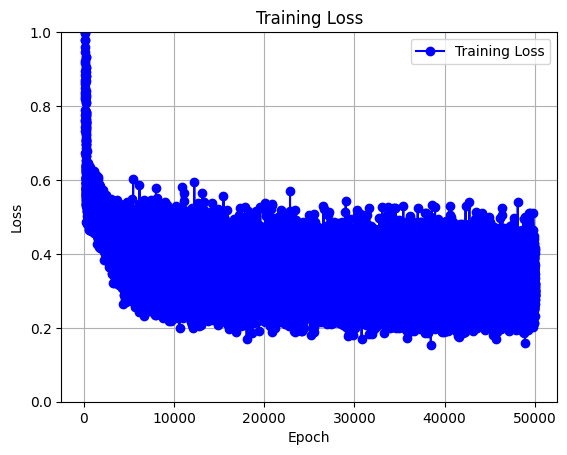

In [9]:
plt.plot(losses, label='Training Loss', linestyle='-', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1])
# plt.yscale('log')
plt.show()

## Sample from D3PM

In [16]:
ts = schedule.generate_schedule()
num_samples = 1000
xt = d3pm.sample_prior((num_samples, D))
for t in ts:
    t = torch.full((xt.shape[0],), t).to(DEVICE)
    logits = model(xt, t)
    xt = d3pm.step(logits, t, xt)

## D3PM Generated Distribution

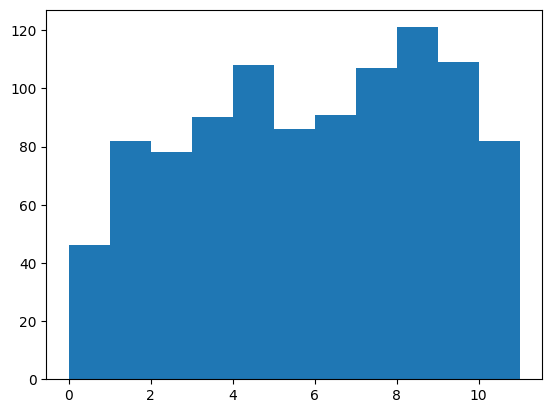

In [17]:
counts = xt.cpu().sum(dim=1).float()
plt.hist(counts.numpy(), bins=range(D+2))
plt.show()

## D3PM Prior Distribution

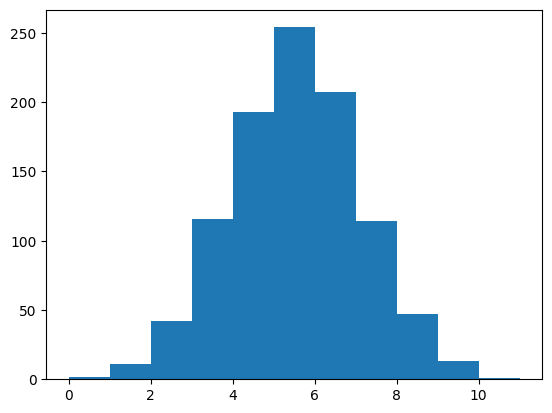

In [18]:
xt = d3pm.sample_prior((num_samples, D))
counts = xt.cpu().sum(dim=1).float()
plt.hist(counts.numpy(), bins=range(D+2))
plt.show()

# Now let's try a new interpolant and a new prior

# MDLM Interpolant

In [3]:
from bionemo.moco.distributions.prior import DiscreteMaskedPrior
from bionemo.moco.interpolants import MDLM
from bionemo.moco.distributions.time import UniformTimeDistribution
from bionemo.moco.schedules.noise.continuous_noise_transforms import CosineExpNoiseTransform
from bionemo.moco.schedules.inference_time_schedules import LinearInferenceSchedule

DEVICE = "cuda:0"
prior = DiscreteMaskedPrior(num_classes = 2, inclusive = False)
time_distribution = UniformTimeDistribution(discrete_time = False)
noise_schedule = CosineExpNoiseTransform()
mdlm = MDLM(time_distribution=time_distribution,
                          prior_distribution=prior,
                          noise_schedule = noise_schedule,
                          device=DEVICE)
schedule = LinearInferenceSchedule(direction = "diffusion", nsteps = 1000)

In [4]:
prior.num_classes # The inclusive flag allows us to chose whether or not to add a dimension

3

## Train MDLM

In [5]:
# training
B = 32 # batch size
D = 10 # dimension
S = 3 # state space

model = Model(D, S)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    
model = model.to(DEVICE)
losses = []
for _ in tqdm(range(50000)):
    num_ones = torch.randint(0, D+1, (B,))
    x1 = (torch.arange(D)[None, :] < num_ones[:, None]).long().to(DEVICE)
    # x1 e.g. [1, 1, 1, 0, 0, 0, 0, 0, 0, 0] or [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
    optimizer.zero_grad()
    # x0 = dfm.sample_prior(x1.shape) # B x D
    t = mdlm.sample_time(B)
    xt = mdlm.interpolate(x1, t)
    logits = model(xt, t) # (B, D, S)
    loss = mdlm.loss(logits, x1, xt, t).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:38<00:00, 506.94it/s]


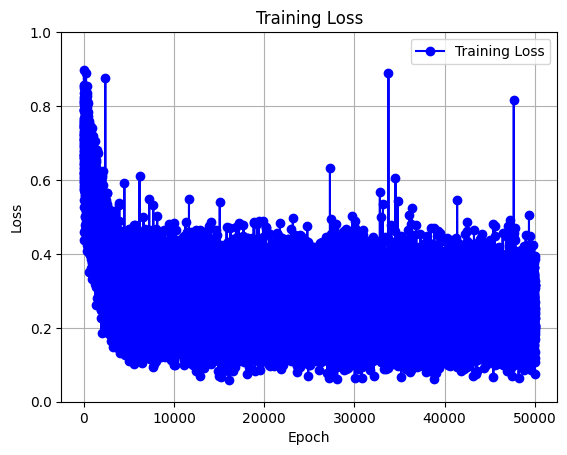

In [6]:
plt.plot(losses, label='Training Loss', linestyle='-', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.ylim([0,1])
# plt.yscale('log')
plt.show()

## Visualize the MASK Prior

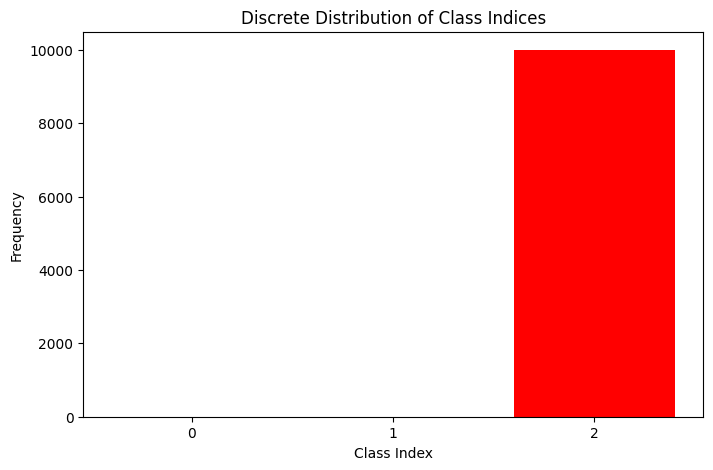

In [8]:
num_samples = 1000
xt = mdlm.sample_prior((num_samples, D))
counts = xt.flatten().cpu()

# Compute frequency of each class index
class_counts = torch.bincount(counts)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_counts)), class_counts.numpy(), color='red')
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.title('Discrete Distribution of Class Indices')
plt.xticks(range(len(class_counts)))  # Set x-ticks to class indices
plt.show()


# Sample from the MDLM trained model

In [9]:
ts = schedule.generate_schedule()
dts = schedule.discretize()
num_samples = 1000
xt = mdlm.sample_prior((num_samples, D))
for dt, t in zip(dts, ts):
    t = torch.full((xt.shape[0],), t).to(DEVICE)
    logits = model(xt, t)
    xt = mdlm.step(logits, t, xt, dt)

# Visualize the class breakdown (green) and generated samples (blue)

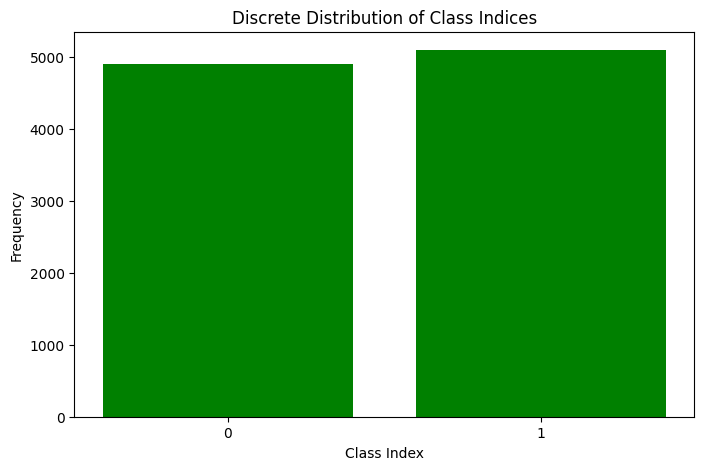

In [10]:

counts = xt.flatten().cpu()

# Compute frequency of each class index
class_counts = torch.bincount(counts)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(range(len(class_counts)), class_counts.numpy(), color='green')
plt.xlabel('Class Index')
plt.ylabel('Frequency')
plt.title('Discrete Distribution of Class Indices')
plt.xticks(range(len(class_counts)))  # Set x-ticks to class indices
plt.show()


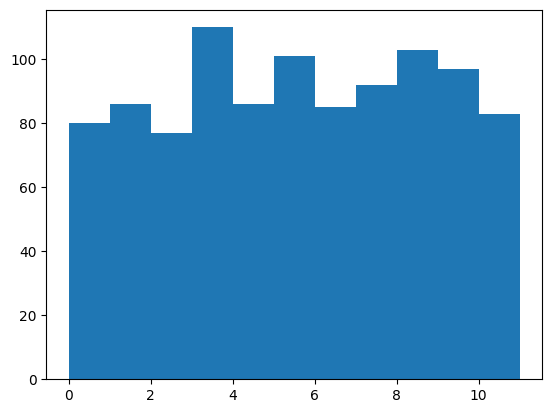

In [11]:
counts = xt.cpu().sum(dim=1).float()
plt.hist(counts.numpy(), bins=range(D+2))
plt.show()

## here we can take binary data and rather than using a uniform prior introduce a MASK state. Here MDLM trained on the same data is able to generate the desired discrete data shown ion blue although starting from pure MASK states seen in red.